---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

---

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно -- рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде -- "яблоки и груши":

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
from google.colab import files
uploaded = files.upload()

Saving apples_pears.csv to apples_pears (2).csv


In [14]:
# data = pd.read_csv("")
data = pd.read_csv('apples_pears.csv')

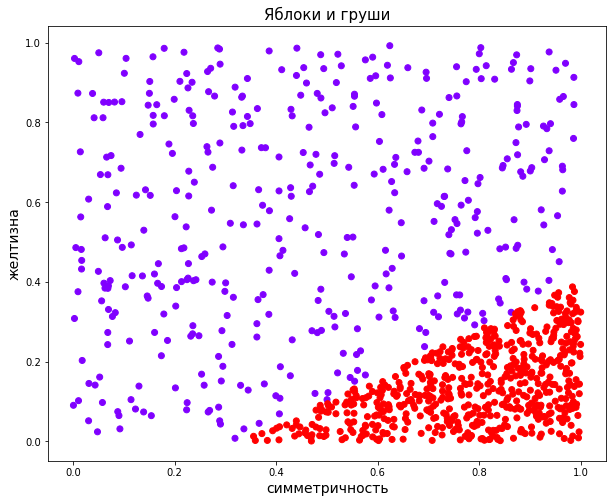

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [16]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [17]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);***

Рассмотрим второй путь (он чуть более user-friendly) и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [18]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [19]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [20]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.5262], grad_fn=<SigmoidBackward>)

Предскажем ещё необученным нейроном:

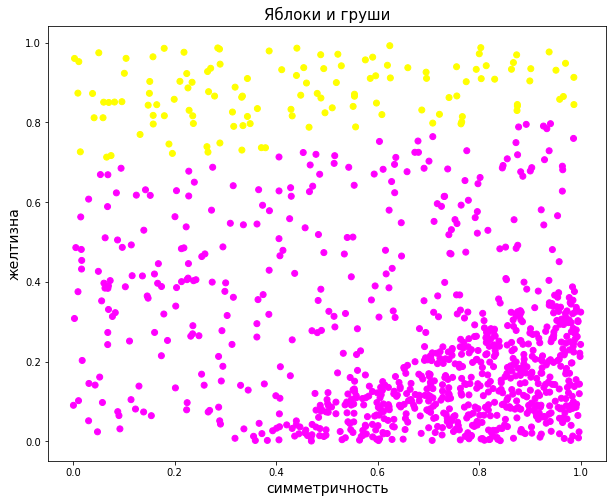

In [21]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [22]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [23]:
# квадратичная функция потерь (можно сделать другую, например, LogLoss)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию работает Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # обнуляем градиенты перед backard_pass'ом (обязательно!)
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # а тут уже обновляем веса
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 302.7946472167969
1 289.2381591796875
2 278.05810546875
3 268.88330078125
4 261.2792053222656
5 254.8480224609375
6 249.26881408691406
7 244.30078125
8 239.7711639404297
9 235.5593719482422
10 231.58285522460938
11 227.7860107421875
12 224.1317901611328
13 220.59584045410156
14 217.16244506835938
15 213.82147216796875
16 210.56654357910156
17 207.39369201660156
18 204.30026245117188
19 201.28457641601562
20 198.34539794921875
21 195.48158264160156
22 192.69216918945312
23 189.97610473632812
24 187.33221435546875
25 184.75933837890625
26 182.25611877441406
27 179.82110595703125
28 177.4528350830078
29 175.14974975585938
30 172.91017150878906
31 170.7324676513672
32 168.61495971679688
33 166.55596923828125
34 164.55374145507812
35 162.60662841796875
36 160.71295166015625
37 158.87103271484375
38 157.07923889160156
39 155.3359832763672
40 153.63967895507812
41 151.9888153076172
42 150.38189697265625
43 148.8174285888672
44 147.2940673828125
45 145.81039428710938
46 144.3651123046875
47 

Обучили. Предскажем теперь:

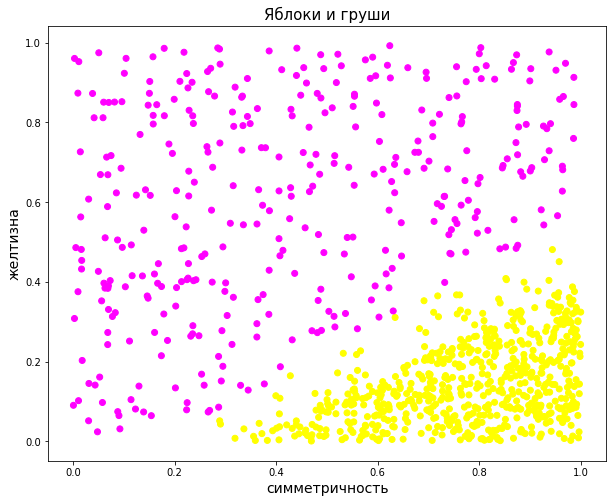

In [24]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Можно добиться лучшего качества работы путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации). Рекомендуем вам поупражняться и использовать функцию потерь `torch.nn.NLLLoss()` или `torch.nn.CrossEntropy()`.

---

Нейрон работет, отличает яблоки от груш. Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

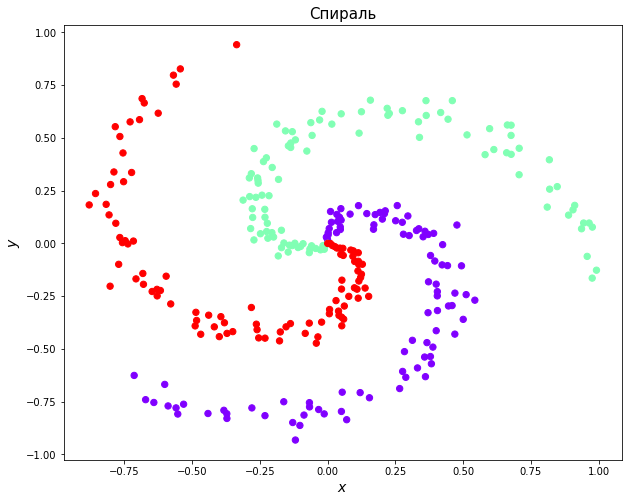

In [25]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable():

In [26]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [27]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Попробуем нейрон с сигмоидой на линейно неразделимой выборке (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [28]:
# N - размер батча (batch_size, нужно для метода оптимизации)
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса 
    optimizer.step()

0 343.7012634277344
1 343.3074951171875
2 342.9161376953125
3 342.5272521972656
4 342.1405944824219
5 341.7560729980469
6 341.3738708496094
7 340.9937744140625
8 340.6159973144531
9 340.2401123046875
10 339.8663330078125
11 339.4949035644531
12 339.1253967285156
13 338.7578125
14 338.3923034667969
15 338.0288391113281
16 337.6672058105469
17 337.3077392578125
18 336.94989013671875
19 336.59423828125
20 336.2402648925781
21 335.8883056640625
22 335.5381774902344
23 335.18975830078125
24 334.8431396484375
25 334.4983825683594
26 334.1551818847656
27 333.8140869140625
28 333.4744873046875
29 333.1364440917969
30 332.8002624511719
31 332.4657897949219
32 332.13299560546875
33 331.80181884765625
34 331.4722595214844
35 331.1441955566406
36 330.8178405761719
37 330.49310302734375
38 330.1697082519531
39 329.8482666015625
40 329.5279541015625
41 329.20916748046875
42 328.89215087890625
43 328.5762634277344
44 328.26214599609375
45 327.94952392578125
46 327.63824462890625
47 327.3282775878906


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


146 302.1823425292969
147 301.97296142578125
148 301.76422119140625
149 301.5563659667969
150 301.3489990234375
151 301.1426696777344
152 300.9369812011719
153 300.7317199707031
154 300.5273742675781
155 300.3236999511719
156 300.1207580566406
157 299.9184265136719
158 299.71710205078125
159 299.5160217285156
160 299.3158874511719
161 299.1163024902344
162 298.91754150390625
163 298.71929931640625
164 298.52191162109375
165 298.3251037597656
166 298.12890625
167 297.93341064453125
168 297.7386779785156
169 297.5443420410156
170 297.35101318359375
171 297.1578369140625
172 296.9658508300781
173 296.7742919921875
174 296.5833435058594
175 296.39300537109375
176 296.2034606933594
177 296.0143737792969
178 295.8259582519531
179 295.63824462890625
180 295.4510803222656
181 295.2645263671875
182 295.0787353515625
183 294.8933410644531
184 294.7088623046875
185 294.5246887207031
186 294.3411560058594
187 294.1582946777344
188 293.9760437011719
189 293.7943420410156
190 293.61346435546875
191 

In [29]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

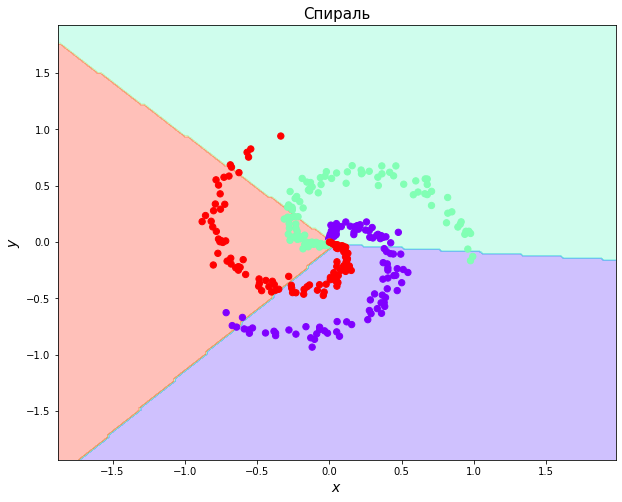

In [30]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Не слищком впечатляет. В следующей практике мы попробуем многослойную нейросеть на этой же задаче.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). *Курс Стэнфорда:  http://cs231n.github.io/*  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*